# Final Project

## Setup Chainer

In [0]:
!curl https://colab.chainer.org/install | sh -
from IPython.display import clear_output
clear_output()

In [0]:
# -*- coding: utf-8 -*-
from __future__ import print_function

import math
import numpy as np
import chainer
from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
import pandas as pd
import time, os, sys, six
import matplotlib.pyplot as plt
import imageio

os.environ['PATH'] += ':/usr/local/cuda-7.5/bin'

In [0]:
data = pd.read_csv('../content/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [4]:
data.Usage.value_counts()
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,2858
1,Digust,334
2,Fear,2987
3,Happy,5141
4,Sad,3445
5,Surprise,2193
6,Neutral,3542


In [5]:
# split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (20499, 3), 
validation shape: (0, 3), 
test shape: (0, 3)


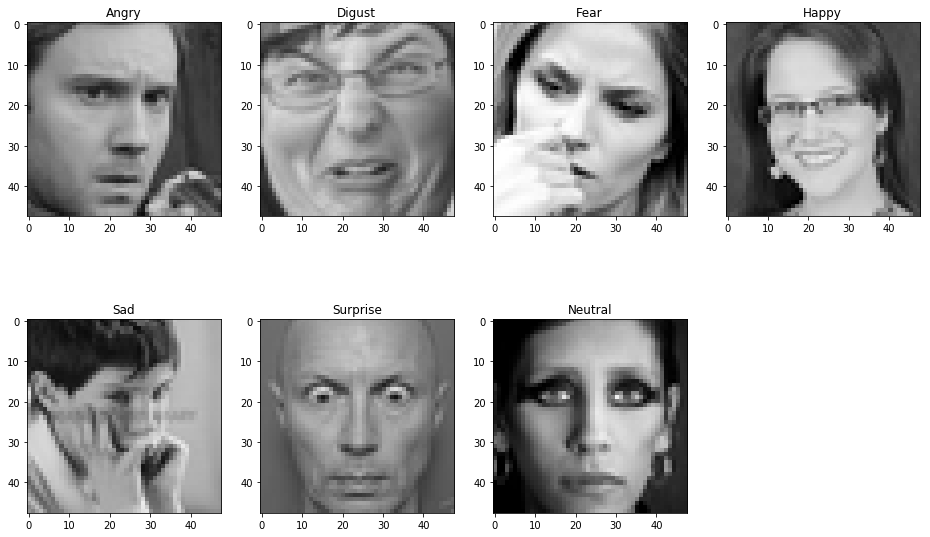

(20500, 3)

In [8]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  
data.shape

In [7]:
#def Transform (data): 
   # img  =  data 
  #  data  = data.Astype(np.uint8) 
  #  data  = data.fromarray (data.transpose(data)) 
  #  data  = data.resize((width, height)) 
  #  data  = np.AsArray(data).Transpose(data).AsType(np.float32)/255.0
  #  return  img
#data.shape

(20500, 3)

In [0]:
if not os.path.exists('Training'):
  os.mkdir('Training')

# Training Dataset
train_image_files = []
for index, row in data_train.iterrows():
  img = row2image(row)
  filename = "Training/{}.jpg".format(index)
  train_image_files.append((filename, img[1]))
  imageio.imwrite(filename, img[0])

In [0]:
if not os.path.exists('Validation'):
  os.mkdir('Validation')
else:
  os.rmdir('Validation')
  os.mkdir('Validation')

# Public Test Dataset (i.e., Validataion Dataset)
val_image_files = []
for index, row in data_val.iterrows():
  img = row2image(row)
  filename = "Validation/{}.jpg".format(index)
  val_image_files.append((filename, img[1]))
  imageio.imwrite(filename, img[0])

In [0]:
if not os.path.exists('Test'):
  os.mkdir('Test')
else:
  !rm -rf 'Test'
  os.mkdir('Test')

# Private Test Dataset
test_image_files = []
for index, row in data_test.iterrows():
  img = row2image(row)
  filename = "Test/{}.jpg".format(index)
  test_image_files.append((filename, img[1]))
  imageio.imwrite(filename, img[0])

In [0]:
train = chainer.datasets.LabeledImageDataset(train_image_files)
validation = chainer.datasets.LabeledImageDataset(val_image_files)
test = chainer.datasets.LabeledImageDataset(test_image_files)

In [0]:
batchsize = 100

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(validation, batchsize, False, False)

In [0]:
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(1, 6, ksize = 5, pad = 0)
            self.bn = L.BatchNormalization()
            self.conv2 = L.Convolution2D(6, 16, ksize = 5, pad =0)
            self.fc1 = L.Linear(400, 120)
            self.fc2 = L.Linear(120, 64)
            self.fc3 = L.Linear(64, 10)
            
            
    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0  # Set to -1 if you use CPU

model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

In [0]:
max_epoch = 10

# Wrap your model by Classifier and include the process of loss calculation within your model.
# Since we do not specify a loss function here, the default 'softmax_cross_entropy' is used.
model = L.Classifier(model)

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [0]:
# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='fer_result')

In [0]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
# trainer.extend(extensions.DumpGraph('main/loss'))

In [0]:
trainer.run()

In [0]:
train_, test_ = chainer.datasets.get_mnist()
train_data, train_label = train_._datasets
train_data = train_data.reshape((len(train_data)), 1, 28, 28)

'''
Replace HOGEHOGE in CNN class with correct answers
'''
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__()
        with self.init_scope():
            # Input: 1 channel of 2-dimensional data
            # Kernel: 5
            # Padding: 0
            # Output: 6 channel of 2-dimensional data
            self.conv1 = L.ConvolutionND(ndim=2, in_channels=1, out_channels=6, ksize=5)
            # Input: 6 channel of 2-dimensional data
            # Kernel: 5
            # Padding: 0
            # Output: 16 channel of 2-dimensional data
            self.conv2 = L.ConvolutionND(ndim=2, in_channels=6, out_channels=16, ksize=5)
            self.fc1 = L.Linear(400, 120)
            self.fc2 = L.Linear(120, 64)
            self.fc3 = L.Linear(64, 10)
            
    def __call__(self, x):
          # 1st convolution
          h = self.conv1(x)
          print('conv1 :',h.shape)
          # 1st pooling
          # Kernel: 2
          # Stride: 2
          # Padding: 0
          h = chainer.functions.max_pooling_2d(h, ksize=2, stride=2)
          print('pool1 :',h.shape)
          # 1st activation
          h = chainer.functions.sigmoid(h)

          # 2nd convolution
          h = self.conv2(h)
          print('conv2 :',h.shape)
          # 2nd pooling
          # Kernel: 2
          # Stride: 2
          # Padding: 0
          h = chainer.functions.max_pooling_2d(h, ksize=2, stride=2)
          print('pool2 :',h.shape)
          # 2nd activation
          h = chainer.functions.sigmoid(h)

          # 1st fully connected
          h = self.fc1(h)
          # activation
          h = chainer.functions.sigmoid(h)
          print('fc1 :',h.shape)

          # 2nd fully connected
          h = self.fc2(h)
          # activation
          h = chainer.functions.sigmoid(h)
          print('fc2 :',h.shape)

          # 3rd fully connected
          h = self.fc3(h)
          # activation
          h = chainer.functions.sigmoid(h)
          print('fc3 :',h.shape)
          return h

cnn = CNN().to_gpu()
x = Variable(cuda.to_gpu(cuda.cupy.asarray(train_data[[0]], dtype=cuda.cupy.float32)))
x = F.resize_images(x, (32,32))
cnn.__call__(x)


In [0]:
cuda.get_device(0).use()
print('network construction...')
cnn = VGG()
cls = L.Classifier(cnn)
cls.to_gpu()
opt = chainer.optimizers.Adam()
opt.use_cleargrads()
opt.setup(cls)
print('done...')

print("data load...")
train_, test_ = chainer.datasets.get_cifar10(withlabel=True, ndim=3)
train_data, train_label = train_._datasets
test_data,  test_label  = test_._datasets
print("done...")


batchsize = 100
train_datasize = len(train_data)
valid_datasize = len(test_data)

train_start = time.time()
for epoch in six.moves.range(200):
  print('epoch %d' % epoch)
  epoch_start = time.time()
  train_loss = 0
  valid_loss = 0
  for i in six.moves.range(0, train_datasize, batchsize):
        indexes = np.random.permutation(train_datasize)
        x = Variable(cuda.to_gpu(cuda.cupy.asarray(train_data[indexes[i :i + batchsize]], dtype=cuda.cupy.float32)))
        t = Variable(cuda.to_gpu(cuda.cupy.asarray(train_label[indexes[i :i + batchsize]], dtype=cuda.cupy.int32)))

        cls.cleargrads()
        opt.update(cls, x, t)

        train_loss += float(cls.loss.data) * len(t.data)
  for i in six.moves.range(0, valid_datasize, batchsize):
        x = Variable(test_data[i :i + batchsize])
        t = Variable(test_label[i :i + batchsize])
        valid_loss += float(cls.loss.data) * len(t.data)
  print("  training loss : "+str(train_loss/60000))
  print("  testing  loss : "+str(valid_loss/10000))
  epoch_end = time.time() - epoch_start
  print("  epoch    time : "+str(epoch_end))

train_time = time.time() - train_start
print('train tims is {}'.format(train_time))